In [14]:
import re, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.isotonic import IsotonicRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import networkx as nx

from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD

np.random.seed(42)

In [15]:
df = pd.read_excel('data/final_risk_data.xlsx')

# изменение типов данных
df['date'] = pd.to_datetime(df['date']).dt.normalize()
for i in ['debit_amount', 'credit_amount']:
    if i in df.columns:
        df[i] = pd.to_numeric(df[i], errors='coerce')
        
# создание колонки с суммой операции
df["amount"] = np.where(df["debit_amount"].notna(), df["debit_amount"], df["credit_amount"])
df["debit_amount"] = df["debit_amount"].fillna(0.0)
df["credit_amount"] = df["credit_amount"].fillna(0.0)

# созжание временных признаков
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
df['month'] = df['date'].dt.month
df["weekofyear"]   = df["date"].dt.isocalendar().week.astype(int)

# Суточные фичи
df['daily_total_debit'] = df.groupby(['debit_inn', 'date'])['debit_amount'].transform('sum')
df['daily_total_credit'] = df.groupby(['credit_inn', 'date'])['credit_amount'].transform('sum')
# посчет транзакций за сутки
df["daily_debit_transaction_count"]    = df.groupby(["debit_inn","date"])["debit_amount"].transform(lambda s: (s > 0).sum())
df["daily_credit_transaction_count"]    = df.groupby(["credit_inn","date"])["credit_amount"].transform(lambda s: (s > 0).sum())
# уникальные отправители и получатели в сутки
df["unique_recipients_per_day"] = df.groupby(["debit_inn","date"])["credit_inn"].transform("nunique")
df["unique_receivers_per_day"] = df.groupby(["credit_inn","date"])["debit_inn"].transform("nunique")

# Доля текущей операции в суточном объёме
df["daily_debit_percent"] = (df["debit_amount"] / df["daily_total_debit"].replace(0, np.nan)).fillna(0.0)
df["daily_credit_percent"] = (df["credit_amount"] / df["daily_total_credit"].replace(0, np.nan)).fillna(0.0)

# Интервалы между операциями (в днях)
df["days_since_last_txn_debit"]  = df.groupby("debit_inn")["date"].diff().dt.days.fillna(9999)
df["days_since_last_txn_credit"] = df.groupby("credit_inn")["date"].diff().dt.days.fillna(9999)

def add_rolling_side(df: pd.DataFrame,
                     side: str,
                     amt_col: str,
                     windows=(7, 14, 30, 90)) -> pd.DataFrame:
    """
    Создает роллинги по суммам/кол-ву транзакций за окна windows для заданной стороны.
    side: 'debit' или 'credit'
    amt_col: имя столбца с суммой для этой стороны (например, 'debit_amount' / 'credit_amount')
    """
    inn_col = f"{side}_inn"
    out_parts = []

    # Берем только нужные колонки (ускоряет groupby)
    need_cols = [inn_col, "date", amt_col]
    sub_all = df[need_cols].copy()
    sub_all[amt_col] = sub_all[amt_col].fillna(0.0)

    for inn, sub in sub_all.groupby(inn_col, sort=False):
        # суточная агрегация по аккаунту
        daily = (sub.groupby("date", as_index=True)[amt_col]
                   .sum()
                   .to_frame("amt_day")
                   .sort_index())

        # непрерывный календарный индекс (чтобы окна не "сжимались")
        idx = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
        daily = daily.reindex(idx, fill_value=0.0)
        daily.index.name = "date"

        # индикатор "была ли операция в день" (для роллинга количества)
        daily["tx_day"] = (daily["amt_day"] > 0).astype(int)

        # роллинги
        for W in windows:
            daily[f"{side}_roll_sum_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).sum()
            daily[f"{side}_roll_cnt_{W}d"]  = daily["tx_day"].rolling(W, min_periods=1).sum()
            daily[f"{side}_roll_mean_{W}d"] = daily["amt_day"].rolling(W, min_periods=1).mean()
            daily[f"{side}_roll_std_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).std().fillna(0.0)
            daily[f"{side}_roll_p95_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).quantile(0.95)

        daily = daily.reset_index()
        daily[inn_col] = inn
        out_parts.append(daily[["date", inn_col] + [c for c in daily.columns if c.startswith(f"{side}_roll_")]])

    rolls = pd.concat(out_parts, ignore_index=True)
    return df.merge(rolls, on=["date", inn_col], how="left")



# Новые роллинги 7/14/30/90 для дебета и кредита
WINDOWS = (7, 14, 30, 90)
df = add_rolling_side(df, side="debit",  amt_col="debit_amount",  windows=WINDOWS)
df = add_rolling_side(df, side="credit", amt_col="credit_amount", windows=WINDOWS)

# ==== 1. Всплески сумм (amount_spike_ratio_7d) ====
df["debit_amount_spike_ratio_7d"]  = df["debit_roll_sum_7d"]  / (df["debit_roll_sum_30d"]/4 + 1e-6)
df["credit_amount_spike_ratio_7d"] = df["credit_roll_sum_7d"] / (df["credit_roll_sum_30d"]/4 + 1e-6)

# ==== 2. Всплески активности (tx_rate_spike_7d) ====
df["debit_tx_rate_spike_7d"]  = df["debit_roll_cnt_7d"]  / (df["debit_roll_cnt_30d"]/4 + 1e-6)
df["credit_tx_rate_spike_7d"] = df["credit_roll_cnt_7d"] / (df["credit_roll_cnt_30d"]/4 + 1e-6)

# ==== 3. Fan-out / Fan-in (уникальные контрагенты) ====
# Для дебета — fan-out (сколько разных получателей на операцию)
df["debit_fan_out_ratio"] = df["unique_recipients_per_day"] / (df["daily_debit_transaction_count"] + 1e-6)

# Для кредита — fan-in (сколько разных отправителей на операцию)
df["credit_fan_in_ratio"] = (
    df.groupby(["credit_inn", "date"])["debit_inn"].transform("nunique") /
    (df["daily_credit_transaction_count"] + 1e-6)
)

# ==== 4. Дисбаланс потоков (in_out_ratio_30d) ====
df["in_out_ratio_30d"] = (df["credit_roll_sum_30d"] + 1e-6) / (df["debit_roll_sum_30d"] + 1e-6)

# ==== 5. Волатильность объёмов (amount_volatility_30d) ====
df["debit_amount_volatility_30d"]  = df["debit_roll_std_30d"]  / (df["debit_roll_mean_30d"]  + 1e-6)
df["credit_amount_volatility_30d"] = df["credit_roll_std_30d"] / (df["credit_roll_mean_30d"] + 1e-6)


# Круглые суммы
df["round_10k"]  = ((df["amount"] % 10000)  == 0).astype(int)
df["round_100k"] = ((df["amount"] % 100000) == 0).astype(int)
df["round_large_amount"] = ((df["round_10k"]==1) | (df["round_100k"]==1)).astype(int)

df.head()


,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose,...,debit_tx_rate_spike_7d,credit_tx_rate_spike_7d,debit_fan_out_ratio,credit_fan_in_ratio,in_out_ratio_30d,debit_amount_volatility_30d,credit_amount_volatility_30d,round_10k,round_100k,round_large_amount
0,2019-01-09,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0c00203649ed677a,e19cc80da09f445f,8d9e0be733f77f1c,10.0,0.0,комиссия внутри сбербанка за пп/пт через дбо с...,...,3.999984,0.000000,1.0,1000000.0,3.333322e-13,0.000000,0.0,0,0,0
1,2019-01-09,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,7682fd5c32e028f5,796a88c244ffcc0a,6931e23e98703aa9,3000000.0,0.0,оплата по счету № 28 от date_9f241b636025 по д...,...,3.999984,0.000000,1.0,1000000.0,3.333322e-13,0.000000,0.0,1,1,1
2,2019-01-10,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0c00203649ed677a,e19cc80da09f445f,8d9e0be733f77f1c,10.0,0.0,комиссия внутри сбербанка за пп/пт через дбо с...,...,3.999992,0.000000,1.0,1000000.0,3.328560e-13,1.410173,0.0,0,0,0
3,2019-01-10,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,e63cf19b76230a3d,21a73421ca00ae87,eed8b1f54ed4366c,4282.0,0.0,оплата по договору электроэнергия по дог.№1124...,...,3.999992,0.000000,1.0,1000000.0,3.328560e-13,1.410173,0.0,0,0,0
4,2019-01-10,d658b4e51c5a5df5,f7185cc66db08da5,ad57c94e5b8df8f6,ded93f97f389bf2c,3e368a63959d285e,d877722ca4e40f98,0.0,1000000.0,перевод денежных средств по договору займа № ч...,...,0.000000,3.999984,1000000.0,1.0,3.000000e+12,0.000000,0.0,1,1,1


In [16]:
# ============================================================
#  Анализ "Назначения платежа": TF-IDF (char 3–5) + стоп-слова риска
# ============================================================

import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# ------------------------------------------------------------
# 1) Регулярные паттерны высокого риска
# ------------------------------------------------------------
STOP_HIGH_PATTERNS = [
    r"\bзайм\w*\b", r"\bвозврат\W*(займ|долг)\w*\b", r"\bпогашен\w*\W*(займ|долг)\w*\b",
    r"\bдолг\w*\b", r"\bоплат\w*\W*(займ|долг)\w*\b",
    r"\bкрипт\w*\b", r"\bбиткоин\w*\b", r"\busdt\b", r"\bbtc\b", r"\bcoin\b",
    r"\bбирж\w*\b", r"\bобмен\w*\b", r"\bвалют\w*\b",
    r"\bналич\w*\b", r"\bобнал\w*\b", r"\bвыдач\w*\W*налич\w*\b",
    r"\bперевод\w*\W*(на|с)\W*карт\w*\b", r"\bперевод\w*\W*физ\w*\b",
    r"\bперевод\w*\W*родствен\w*\б", r"\bперевод\w*\W*средств\b",
    r"\bбез\W*договор\w*\b",
    r"\bпожертв\w*\b", r"\bблаготвор\w*\б", r"\bдарен\w*\b",
    r"\bагентск\w*\W*вознагражд\w*\б",
    # r"\bкомисси\w*\W*вознагражд\w*\b",
    r"\bвознагражд\w*\b",
    r"\bцесс\w*\б", r"\bпоручител\w*\b", r"\bзалог\w*\b",
    r"\bофшор\w*\б", r"\bиностран\w*\W*перевод\w*\b", r"\bswift\b",
    r"\bличн\w*\W*нужд\w*\б", r"\bпередач\w*\W*актив\w*\б",
    r"\bвклад\w*\б", r"\bдепозит\w*\б",
]
STOP_HIGH_RE = re.compile("|".join(STOP_HIGH_PATTERNS), flags=re.IGNORECASE)

# ------------------------------------------------------------
# 2) Очистка текста
# ------------------------------------------------------------
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[^a-zа-я0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["purpose_clean"] = df["purpose"].apply(clean_text)

# ------------------------------------------------------------
# 3) Метка наличия стоп-слов риска
# ------------------------------------------------------------
df["purpose_stopword_high"] = df["purpose_clean"].str.contains(STOP_HIGH_RE, na=False)

# ------------------------------------------------------------
# 4) TF-IDF (char-level 3–5-граммы) + SVD
# ------------------------------------------------------------
texts = df["purpose_clean"].astype(str).tolist()

tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=1
)
X_tfidf = tfidf.fit_transform(texts)
print(f"TF-IDF матрица: {X_tfidf.shape[0]} × {X_tfidf.shape[1]}")

# SVD для сжатия (например, до 50 компонент)
svd_k_target = 50
max_svd = max(1, min(X_tfidf.shape[0] - 1, X_tfidf.shape[1] - 1))
n_svd = min(svd_k_target, max_svd)

svd = TruncatedSVD(n_components=n_svd, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

for i in range(X_svd.shape[1]):
    df[f"purpose_svd_{i+1}"] = X_svd[:, i]

expl_var = svd.explained_variance_ratio_.sum()
print(f"SVD explained variance (k={X_svd.shape[1]}): {expl_var:.3f}")

# ------------------------------------------------------------
# 5) Результат
# ------------------------------------------------------------
svd_cols = [c for c in df.columns if c.startswith("purpose_svd_")]
cols_show = ["purpose", "purpose_stopword_high"] + svd_cols

print(f"\n✅ Добавлены признаки: {len(svd_cols)} SVD-компонент + метка стоп-слов")
print(df[cols_show].head())

TF-IDF матрица: 2688 × 45426
SVD explained variance (k=50): 0.545

✅ Добавлены признаки: 50 SVD-компонент + метка стоп-слов
                                             purpose  purpose_stopword_high  \
0  комиссия внутри сбербанка за пп/пт через дбо с...                  False   
1  оплата по счету № 28 от date_9f241b636025 по д...                  False   
2  комиссия внутри сбербанка за пп/пт через дбо с...                  False   
3  оплата по договору электроэнергия по дог.№1124...                  False   
4  перевод денежных средств по договору займа № ч...                   True   

   purpose_svd_1  purpose_svd_2  purpose_svd_3  purpose_svd_4  purpose_svd_5  \
0       0.708416      -0.202923      -0.110215      -0.029243       0.142140   
1       0.122677       0.236405      -0.200400      -0.017372      -0.097021   
2       0.602413      -0.212909      -0.103785      -0.020422       0.124845   
3       0.108051       0.160672      -0.135616      -0.000770      -0.035201   
4

In [17]:
# =========================
# GCN Autoencoder (GAE) для AML на транзакциях по ИНН
# С фильтрацией по участию ИНН в графе (MIN_DEG)
# =========================

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from tqdm import tqdm

# -------------------------
# ПАРАМЕТРЫ
# -------------------------
MIN_DEG = 1  # количество контрагентов
EPOCHS = 300 # сколько раз нейросеть пройдет весь граф при обучении 
LR = 1e-3 # показывает насколько сильно обновляются веса в нейросети на каждом шаге
WDECAY = 1e-4 # маленький штраф за слишком большие веса
HIDDEN = 64 #
LATENT = 32 #
DROPOUT = 0.3 #
NEG_POS_RATIO = 1.0  # сколько негативных пар на каждое позитивное ребро

device = torch.device('cpu')

# -------------------------
# 1) Построение графа ИНН–ИНН и фич узлов
# -------------------------
# Ожидается DataFrame df со столбцами, как ты присылал (debit_inn/credit_inn и числовые признаки).

inn_series = pd.concat([df['debit_inn'], df['credit_inn']], ignore_index=True)
unique_inn = pd.Index(inn_series.dropna().unique())
inn2id = {inn: i for i, inn in enumerate(unique_inn)}
num_nodes = len(unique_inn)

edges_src_s = df['debit_inn'].map(inn2id)
edges_dst_s = df['credit_inn'].map(inn2id)
mask_valid = (edges_src_s.notna() & edges_dst_s.notna())
edges_src = edges_src_s[mask_valid].astype(int).values
edges_dst = edges_dst_s[mask_valid].astype(int).values

# Неориентированный граф для энкодера (добавим обратные рёбра):
edge_index = torch.tensor([edges_src, edges_dst], dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

# Выберем числовые признаки для профиля ИНН
exclude_cols = [
    'date','debit_account','debit_name','debit_inn',
    'credit_account','credit_name','credit_inn','purpose'
] + [f"purpose_svd_{i}" for i in range(1,51)]

numeric_cols = [c for c in df.columns
                if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]

df_num = df[numeric_cols].copy().fillna(0)

# Агрегации по ИНН (как дебитор и как кредитор), затем усредняем
agg_debit = df.groupby('debit_inn')[numeric_cols].mean().reindex(unique_inn, fill_value=0)
agg_credit = df.groupby('credit_inn')[numeric_cols].mean().reindex(unique_inn, fill_value=0)
node_features = (agg_debit.values + agg_credit.values) / 2.0

# Масштабирование
scaler = StandardScaler()
node_features = scaler.fit_transform(node_features)

x = torch.tensor(node_features, dtype=torch.float, device=device)
ei = edge_index.to(device)

data_pg = Data(x=x, edge_index=ei.cpu())  # для печати размеров
print(data_pg)

# -------------------------
# 2) Модель и torch-only negative sampling
# -------------------------
class GCNEncoder(nn.Module):
    def __init__(self, in_ch, hidden=64, out_ch=32, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hidden)
        self.conv2 = GCNConv(hidden, out_ch)
        self.dropout = dropout

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        z = self.conv2(h, edge_index)
        return z

def torch_negative_sampling(edge_index: torch.Tensor, num_nodes: int, num_neg_samples: int):
    """Чисто Torch негативный сэмплинг: выдаёт пары (u,v), которых нет в edge_index и u!=v."""
    device = edge_index.device
    u = edge_index[0].to(torch.long)
    v = edge_index[1].to(torch.long)
    enc_exist = (u * num_nodes + v).unique()
    got = 0
    chunks = []
    batch = max(1024, min(num_neg_samples, 65536))
    while got < num_neg_samples:
        uu = torch.randint(0, num_nodes, (batch,), device=device)
        vv = torch.randint(0, num_nodes, (batch,), device=device)
        enc = uu * num_nodes + vv
        mask = (~torch.isin(enc, enc_exist)) & (uu != vv)
        if mask.any():
            pair = torch.stack([uu[mask], vv[mask]], dim=0)
            chunks.append(pair[:, : (num_neg_samples - got)])
            got += chunks[-1].size(1)
        if batch < num_neg_samples:
            batch = min(num_neg_samples, batch * 2)
    return torch.cat(chunks, dim=1)

def recon_loss(z, edge_index, num_nodes, neg_ratio=1.0):
    pos_i, pos_j = edge_index
    num_neg = int(pos_i.numel() * neg_ratio)
    neg_edge_index = torch_negative_sampling(edge_index, num_nodes=num_nodes, num_neg_samples=num_neg)

    pos_logits = (z[pos_i] * z[pos_j]).sum(dim=-1)
    neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=-1)

    pos_loss = F.binary_cross_entropy_with_logits(pos_logits, torch.ones_like(pos_logits))
    neg_loss = F.binary_cross_entropy_with_logits(neg_logits, torch.zeros_like(neg_logits))
    return pos_loss + neg_loss

model = GCNEncoder(in_ch=x.size(1), hidden=HIDDEN, out_ch=LATENT, dropout=DROPOUT).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WDECAY)

# -------------------------
# 3) Обучение
# -------------------------
for ep in tqdm(range(1, EPOCHS + 1), desc="Training", unit="epoch"):
    model.train()
    opt.zero_grad()
    z = model(x, ei)
    loss = recon_loss(z, ei, num_nodes=num_nodes, neg_ratio=NEG_POS_RATIO)
    loss.backward()
    opt.step()
    if ep % 50 == 0 or ep == 1:
        tqdm.write(f"Epoch {ep:03d} | Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    z = model(x, ei)

# -------------------------
# 4) Скоринг аномалий (с фильтром по участию ИНН)
# -------------------------
sigmoid = torch.sigmoid

# Исходные направленные рёбра (без обратных), для скоринга рёбер:
orig_src = torch.tensor(edges_src, dtype=torch.long, device=device)
orig_dst = torch.tensor(edges_dst, dtype=torch.long, device=device)

with torch.no_grad():
    edge_logits = (z[orig_src] * z[orig_dst]).sum(dim=-1)
    edge_p = sigmoid(edge_logits)
edge_score = (1.0 - edge_p).cpu().numpy()  # выше — подозрительнее

# Участие каждого ИНН (сколько раз встречается как источник/получатель в исходных рёбрах)
participation = np.bincount(
    np.concatenate([edges_src, edges_dst]),
    minlength=num_nodes
)

# Рёбра учитываем только если оба конца имеют участие >= MIN_DEG
keep_edge_mask = (participation[edges_src] >= MIN_DEG) & (participation[edges_dst] >= MIN_DEG)

edges_src_f = edges_src[keep_edge_mask]
edges_dst_f = edges_dst[keep_edge_mask]
edge_score_f = edge_score[keep_edge_mask]

# Top-20 подозрительных связей (агрегация по (debit_inn, credit_inn))
edge_keys = pd.MultiIndex.from_arrays(
    [df.loc[mask_valid, 'debit_inn'].values[keep_edge_mask],
     df.loc[mask_valid, 'credit_inn'].values[keep_edge_mask]],
    names=['debit_inn','credit_inn']
)
edge_df = pd.DataFrame({'edge_score': edge_score_f}, index=edge_keys).groupby(level=[0,1]).mean()
edge_top = edge_df.sort_values('edge_score', ascending=False).head(20)
print(f"\nTop-20 подозрительных связей (ИНН→ИНН), порог участия узлов ≥ {MIN_DEG}:")
display(edge_top)

# --- Узловые скора ---
num_nodes = int(num_nodes)
node_accum = np.zeros(num_nodes, dtype=np.float64)
node_cnt   = np.zeros(num_nodes, dtype=np.int64)

# учитываем только отфильтрованные рёбра
for s, d, sc in zip(edges_src_f, edges_dst_f, edge_score_f):
    node_accum[s] += sc; node_cnt[s] += 1
    node_accum[d] += sc; node_cnt[d] += 1

node_score_edges = np.divide(node_accum, np.maximum(node_cnt, 1))

# изолированность по косинусу (на неориентированном графе), потом отфильтруем узлы ниже порога
with torch.no_grad():
    zn = F.normalize(z, dim=1)

cos_accum = np.zeros(num_nodes, dtype=np.float64)
cos_cnt   = np.zeros(num_nodes, dtype=np.int64)
ei_cpu = ei.detach().cpu().numpy()

for u, v in zip(ei_cpu[0], ei_cpu[1]):
    cos = float((zn[u] * zn[v]).sum().cpu())
    cos_accum[u] += cos; cos_cnt[u] += 1

node_isolation = 1.0 - np.divide(cos_accum, np.maximum(cos_cnt, 1))

# Узлам с участием < MIN_DEG не присваиваем скор (NaN)
node_score_edges[participation < MIN_DEG] = np.nan
node_isolation[participation < MIN_DEG]   = np.nan

node_tbl = pd.DataFrame({
    'inn': unique_inn.values,
    'participation': participation,
    'edge_based_score': node_score_edges,
    'isolation_score': node_isolation
}).set_index('inn')
node_tbl['node_score'] = 0.5*node_tbl['edge_based_score'] + 0.5*node_tbl['isolation_score']

node_top = node_tbl.dropna(subset=['node_score']) \
                   .sort_values('node_score', ascending=False).head(20)

print(f"\nTop-20 подозрительных ИНН (узлы с участием ≥ {MIN_DEG}):")
display(node_top)

# -------------------------
# 5) Примечания
# -------------------------
# - Меняй MIN_DEG для контроля "мусорных" узлов с единичными транзакциями.
# - Для очень больших графов снизь EPOCHS или используй GraphSAGE с neighbor sampling.
# - Если важно направление и/или фичи рёбер, сделай декодер-MLP на [z_u, z_v, edge_features].

Data(x=[111, 71], edge_index=[2, 5348])


Training:  10%|██████▉                                                            | 31/300 [00:00<00:01, 155.48epoch/s]

Epoch 001 | Loss: 0.9593


Training:  27%|██████████████████▎                                                | 82/300 [00:00<00:01, 163.70epoch/s]

Epoch 050 | Loss: 0.8264


Training:  39%|█████████████████████████▌                                        | 116/300 [00:00<00:01, 164.45epoch/s]

Epoch 100 | Loss: 0.7678


Training:  56%|████████████████████████████████████▉                             | 168/300 [00:01<00:00, 165.84epoch/s]

Epoch 150 | Loss: 0.8649


Training:  73%|████████████████████████████████████████████████▏                 | 219/300 [00:01<00:00, 166.00epoch/s]

Epoch 200 | Loss: 0.8082


Training:  90%|███████████████████████████████████████████████████████████▍      | 270/300 [00:01<00:00, 159.59epoch/s]

Epoch 250 | Loss: 0.7793


Training: 100%|██████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 163.36epoch/s]


Epoch 300 | Loss: 1.0955

Top-20 подозрительных связей (ИНН→ИНН), порог участия узлов ≥ 1:


edge_score
debit_inn        credit_inn                  
d877722ca4e40f98 480b91025f5be8d0    0.017527
                 1c3f31b0b8c13d69    0.017527
                 6ef5667d7851dcbc    0.017527
                 6d806e49c5774c77    0.017527
                 699e6f31660016bf    0.017527
                 5a0eeb2c5b3da864    0.017527
                 582da928bb55efa7    0.017527
                 532f3d84ba4caf61    0.017527
                 52eac05f8c0cd90c    0.017527
                 4d16cd529b7aadf6    0.017527
                 4b69be7da3b45651    0.017527
                 4a321015f6da531b    0.017527
0b84385c8f9b55ba d877722ca4e40f98    0.017527
d877722ca4e40f98 4568a94b7a61a595    0.017527
                 446b8f53fb0a0387    0.017527
                 4242481819cb0f02    0.017527
                 3f64d17c465bbf92    0.017527
                 3a9c5401f637dd8d    0.017527
                 385844c16cc4dcb1    0.017527
                 35a482f88fe31cd3    0.017527


Top-20 подозрительных ИНН (узлы с участием ≥ 1):


,participation,edge_based_score,isolation_score,node_score
inn,,,,
333706e1b48a76ee,1,0.000000,0.906234,0.453117
516b9fe460a8ab7c,1,0.000000,0.802209,0.401104
d8104c0f1919d0ef,3,0.017527,0.570314,0.293920
4a321015f6da531b,5,0.017527,0.570314,0.293920
d18b9e5e99859a85,1,0.017527,0.570314,0.293920
e48c848058fa9e0d,2,0.017527,0.570314,0.293920
767c3f5f72b4494f,2,0.017527,0.570314,0.293920
4b69be7da3b45651,1,0.017527,0.570314,0.293920
2b652fbf87f8d72b,1,0.017527,0.570314,0.293920


ИНН с >=10 дебетных транзакций: 10
ИНН с >=10 кредитных транзакций: 27


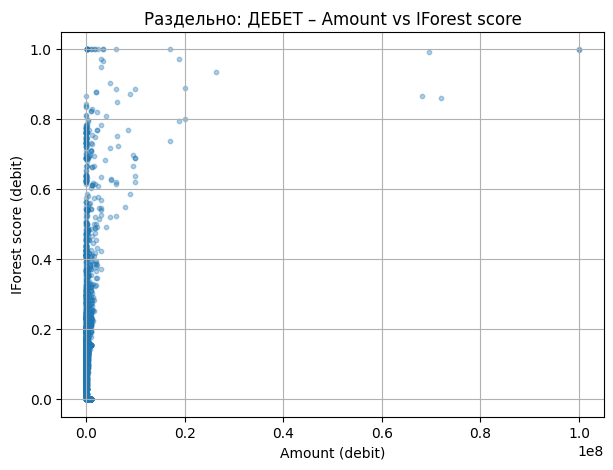

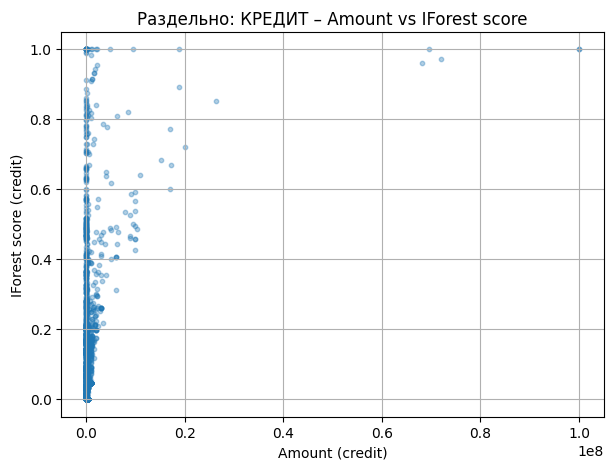

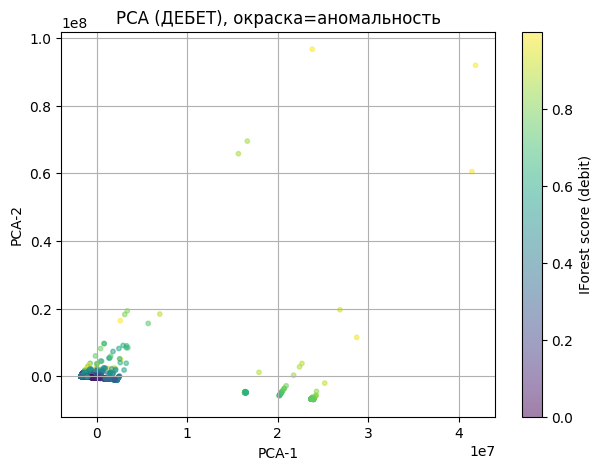

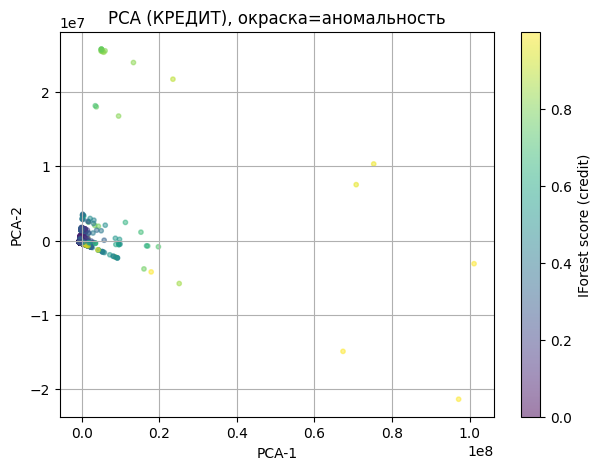

,txn_id,date,inn,side,amount,purpose,iforest_score_debit
1899,NaN,2021-07-06,8d9e0be733f77f1c,debit,100000000.0,выдача кредита по договору n600210017 от 24 ию...,1.000000
14,NaN,2019-01-15,ad57c94e5b8df8f6,debit,3400000.0,перевод денежных средств по договору займа № ч...,1.000000
493,NaN,2019-10-16,9d8f54ae3b88911b,debit,17000000.0,оплата по договору беспроцентного займа №ти-17...,1.000000
1799,NaN,2021-05-21,5ae9eeb0d29bc5c0,debit,2350000.0,перевод денежных средств по договору № пи-1/28...,1.000000
2242,NaN,2021-11-26,nan,debit,3500000.0,взнос займа по договору №34 от date_e98770c5fd...,1.000000
...,...,...,...,...,...,...,...
492,NaN,2019-10-16,d877722ca4e40f98,debit,17000000.0,оплата по счету № 20 от date_aa5e303a04cd аван...,0.738073
1953,NaN,2021-07-12,d877722ca4e40f98,debit,7705.0,оплата по счету № 6042 от 09.07.21г спецодежда...,0.736144
1952,NaN,2021-07-12,d877722ca4e40f98,debit,2790.0,оплата по договору электроэнергия по дог.№1124...,0.734545
1942,NaN,2021-07-09,d877722ca4e40f98,debit,80000.0,оплата по счету № 73 от date_63da1f80aee8 стро...,0.733509


,txn_id,date,inn,side,amount,purpose,iforest_score_credit
1898,NaN,2021-07-06,8d9e0be733f77f1c,credit,1.000000e+08,формирование покрытия по внутрироссийскому акк...,1.000000
1945,NaN,2021-07-09,6931e23e98703aa9,credit,6.950000e+07,окончательная оплата по счету №9 от date_aaac9...,1.000000
2508,NaN,2022-08-02,1b21a7645f64d170,credit,4.869204e+06,по решению о взыскании № 5593 от date_11c36260...,1.000000
1979,NaN,2021-07-20,80799e1a6646b6dc,credit,1.214381e+06,налог на имущество организаций за 1 квартал 20...,1.000000
1669,NaN,2021-03-31,480b91025f5be8d0,credit,4.000000e+05,частичный возврат займа по договору №2-ои/1509...,1.000000
...,...,...,...,...,...,...,...
1886,NaN,2021-06-30,d877722ca4e40f98,credit,1.729715e+07,"acc_cd27e0d43c60;ст. 176 нк рф, год: 2021 реше...",0.668435
2074,NaN,2021-09-03,8d9e0be733f77f1c,credit,4.909513e+04,заработная плата по реестру №22 от date_2ee8be...,0.666410
695,NaN,2020-03-27,ca3891c167141f4d,credit,1.287300e+02,взносы на обязательное страхование от несчастн...,0.664769
2520,NaN,2022-08-03,480b91025f5be8d0,credit,8.995100e+02,оплата по договору аренды кабинета по сч.№23 о...,0.661495


✅ Сохранено: top100_anomalous_txn_debit.csv
✅ Сохранено: top100_anomalous_txn_credit.csv


In [11]:
# === Ячейка 2. Раздельный анализ: отдельные модели для дебета и для кредита ===
# Для каждого ИНН считаем аномалии отдельно в дебетных и отдельно в кредитных операциях.
# Фильтр: в каждой роли ИНН должен иметь >=30 транзакций по этой роли.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

RANDOM_STATE = 42
MIN_TX_PER_INN = 10

# -------- 0) Подготовка отдельных таблиц --------
# ДЕБЕТ
deb_cols = [
    "id","date","purpose","amount","debit_inn",
    "debit_roll_cnt_30d","debit_roll_mean_30d","debit_roll_std_30d",
    "debit_amount_spike_ratio_7d","debit_tx_rate_spike_7d","debit_amount_volatility_30d"
]
for c in deb_cols:
    if c not in df.columns: df[c] = 0.0 if c not in ["id","date","purpose","debit_inn"] else df.get(c, np.nan)

deb = pd.DataFrame({
    "txn_id": df["id"],
    "date": pd.to_datetime(df["date"]),
    "inn": df["debit_inn"].astype(str),
    "side": "debit",
    "purpose": df["purpose"].astype(str),
    "amount": df["amount"].astype(float),
    # фичи роли
    "roll_cnt_30d": df["debit_roll_cnt_30d"].astype(float),
    "roll_mean_30d": df["debit_roll_mean_30d"].astype(float),
    "roll_std_30d": df["debit_roll_std_30d"].astype(float),
    "amount_spike_ratio_7d": df["debit_amount_spike_ratio_7d"].astype(float),
    "tx_rate_spike_7d": df["debit_tx_rate_spike_7d"].astype(float),
    "amount_volatility_30d": df["debit_amount_volatility_30d"].astype(float),
})

# КРЕДИТ
cred_cols = [
    "id","date","purpose","amount","credit_inn",
    "credit_roll_cnt_30d","credit_roll_mean_30d","credit_roll_std_30d",
    "credit_amount_spike_ratio_7d","credit_tx_rate_spike_7d","credit_amount_volatility_30d"
]
for c in cred_cols:
    if c not in df.columns: df[c] = 0.0 if c not in ["id","date","purpose","credit_inn"] else df.get(c, np.nan)

cred = pd.DataFrame({
    "txn_id": df["id"],
    "date": pd.to_datetime(df["date"]),
    "inn": df["credit_inn"].astype(str),
    "side": "credit",
    "purpose": df["purpose"].astype(str),
    "amount": df["amount"].astype(float),
    "roll_cnt_30d": df["credit_roll_cnt_30d"].astype(float),
    "roll_mean_30d": df["credit_roll_mean_30d"].astype(float),
    "roll_std_30d": df["credit_roll_std_30d"].astype(float),
    "amount_spike_ratio_7d": df["credit_amount_spike_ratio_7d"].astype(float),
    "tx_rate_spike_7d": df["credit_tx_rate_spike_7d"].astype(float),
    "amount_volatility_30d": df["credit_amount_volatility_30d"].astype(float),
})

# -------- 1) Фильтры по количеству транзакций в каждой роли --------
deb_eligible = set(deb.groupby("inn").size()[lambda s: s>=MIN_TX_PER_INN].index)
cred_eligible = set(cred.groupby("inn").size()[lambda s: s>=MIN_TX_PER_INN].index)

deb_w = deb[deb["inn"].isin(deb_eligible)].copy()
cred_w = cred[cred["inn"].isin(cred_eligible)].copy()

print(f"ИНН с >={MIN_TX_PER_INN} дебетных транзакций: {len(deb_eligible):,}")
print(f"ИНН с >={MIN_TX_PER_INN} кредитных транзакций: {len(cred_eligible):,}")
if len(deb_eligible)==0 and len(cred_eligible)==0:
    raise RuntimeError("Нет ИНН с достаточным числом транзакций ни в дебете, ни в кредите.")

# -------- 2) IsolationForest по КАЖДОЙ роли и КАЖДОМУ ИНН --------

feat_cols = [
    "amount","roll_cnt_30d","roll_mean_30d","roll_std_30d",
    "amount_spike_ratio_7d","tx_rate_spike_7d","amount_volatility_30d", "is_weekend", "is_month_end",

    
]

# оставляем первые 7 так как в PCA остальные колонки имеют 0 вес => создают шумы 
# feat_cols = [
#     # базовые суммы
#     "amount",
#     # поведенческие окна
#    "roll_cnt_30d","roll_mean_30d","roll_std_30d",
#     "amount_spike_ratio_7d","tx_rate_spike_7d","amount_volatility_30d",
#     # активность
#     "daily_debit_transaction_count", "daily_credit_transaction_count",
#     # доли в дневном объеме
#     "daily_debit_percent", "daily_credit_percent",
#     # интервалы между операциями
#     "days_since_last_txn_debit", "days_since_last_txn_credit",
#     # связи (fan-out / fan-in)
#     "debit_fan_out_ratio", "credit_fan_in_ratio",
#     # баланс вход/выход
#     "in_out_ratio_30d",
#     # округлённые суммы
#     "round_large_amount",
#     # время
#     "day_of_week", "is_weekend", "is_month_end"
# ]


for c in feat_cols:
    if c not in deb_w.columns: deb_w[c] = 0.0
    if c not in cred_w.columns: cred_w[c] = 0.0

deb_w["iforest_score_debit"] = np.nan
cred_w["iforest_score_credit"] = np.nan

iso_params = dict(n_estimators=300, contamination=0.02, random_state=RANDOM_STATE)

# Дебет
for inn in sorted(deb_eligible):
    sub = deb_w[deb_w["inn"]==inn]
    X = sub[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    iso = IsolationForest(**iso_params)
    iso.fit(Xs)
    raw = -iso.score_samples(Xs)
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)
    deb_w.loc[sub.index, "iforest_score_debit"] = s

# Кредит
for inn in sorted(cred_eligible):
    sub = cred_w[cred_w["inn"]==inn]
    X = sub[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    iso = IsolationForest(**iso_params)
    iso.fit(Xs)
    raw = -iso.score_samples(Xs)
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)
    cred_w.loc[sub.index, "iforest_score_credit"] = s


    

# -------- 3) Scatter-графики по ролям --------
# 3.1 Дебет: Amount vs iforest_score_debit
if len(deb_w):
    plt.figure(figsize=(7,5))
    plt.scatter(deb_w["amount"], deb_w["iforest_score_debit"], s=10, alpha=0.35)
    plt.xlabel("Amount (debit)")
    plt.ylabel("IForest score (debit)")
    plt.title("Раздельно: ДЕБЕТ – Amount vs IForest score")
    plt.grid(True)
    plt.show()

# 3.2 Кредит: Amount vs iforest_score_credit
if len(cred_w):
    plt.figure(figsize=(7,5))
    plt.scatter(cred_w["amount"], cred_w["iforest_score_credit"], s=10, alpha=0.35)
    plt.xlabel("Amount (credit)")
    plt.ylabel("IForest score (credit)")
    plt.title("Раздельно: КРЕДИТ – Amount vs IForest score")
    plt.grid(True)
    plt.show()

# (доп) PCA-проекции для каждой роли
if len(deb_w):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(deb_w[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)
    plt.figure(figsize=(7,5))
    plt.scatter(Xp[:,0], Xp[:,1], c=deb_w["iforest_score_debit"], s=10, alpha=0.5)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2"); plt.title("PCA (ДЕБЕТ), окраска=аномальность")
    plt.colorbar(label="IForest score (debit)")
    plt.grid(True)
    plt.show()

if len(cred_w):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(cred_w[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)
    plt.figure(figsize=(7,5))
    plt.scatter(Xp[:,0], Xp[:,1], c=cred_w["iforest_score_credit"], s=10, alpha=0.5)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2"); plt.title("PCA (КРЕДИТ), окраска=аномальность")
    plt.colorbar(label="IForest score (credit)")
    plt.grid(True)
    plt.show()

# -------- 4) Топ-100 самых подозрительных транзакций ПО ОТДЕЛЬНОСТИ --------
top100_debit = deb_w.sort_values("iforest_score_debit", ascending=False).head(100).copy()
top100_credit = cred_w.sort_values("iforest_score_credit", ascending=False).head(100).copy()

cols_out_deb = ["txn_id","date","inn","side","amount","purpose","iforest_score_debit"]
cols_out_cred = ["txn_id","date","inn","side","amount","purpose","iforest_score_credit"]

display(top100_debit[cols_out_deb])
display(top100_credit[cols_out_cred])

# Сохранение
out_deb = "top100_anomalous_txn_debit.csv"
out_cred = "top100_anomalous_txn_credit.csv"
top100_debit[cols_out_deb].to_csv(out_deb, index=False, encoding="utf-8-sig")
top100_credit[cols_out_cred].to_csv(out_cred, index=False, encoding="utf-8-sig")
print(f"✅ Сохранено: {out_deb}")
print(f"✅ Сохранено: {out_cred}")


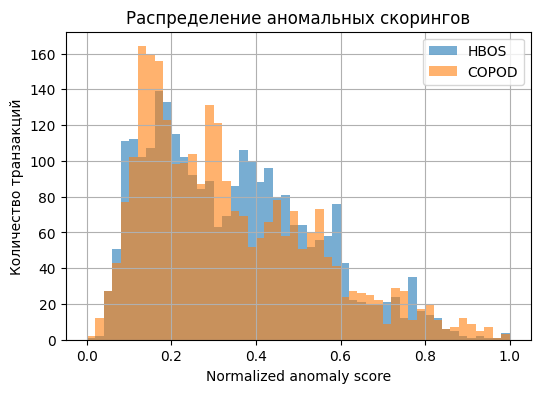

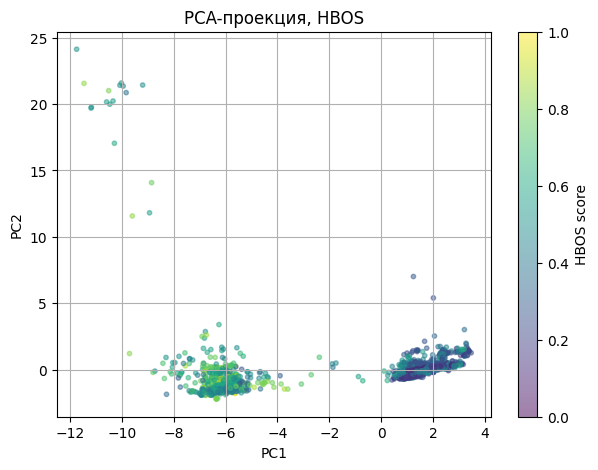

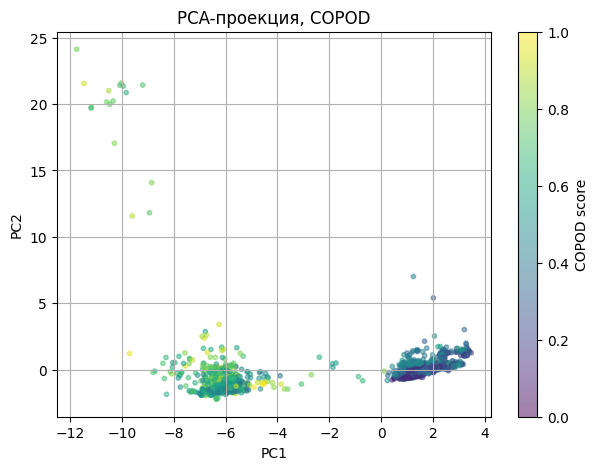

✅ Сохранено: top100_hbos_tfidf.csv, top100_copod_tfidf.csv
Топ-10 наиболее информативных признаков по PCA:
                                PCA_importance
credit_roll_std_30d                   0.646799
in_out_ratio_30d                      0.640984
credit_roll_mean_30d                  0.639870
credit_fan_in_ratio                   0.346314
daily_credit_transaction_count        0.331952
debit_fan_out_ratio                   0.330255
credit_roll_cnt_30d                   0.310874
credit_tx_rate_spike_7d               0.305851
credit_amount_volatility_30d          0.286589
debit_amount_volatility_30d           0.282102


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# если PyOD не установлен: pip install pyod
from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD


feat_cols = [
    # базовая сумма
    "amount",

    # поведенческие окна: дебет
    "debit_roll_cnt_30d", "debit_roll_mean_30d", "debit_roll_std_30d",
    "debit_amount_spike_ratio_7d", "debit_tx_rate_spike_7d", "debit_amount_volatility_30d",

    # поведенческие окна: кредит
    "credit_roll_cnt_30d", "credit_roll_mean_30d", "credit_roll_std_30d",
    "credit_amount_spike_ratio_7d", "credit_tx_rate_spike_7d", "credit_amount_volatility_30d",

    # активность за день
    "daily_debit_transaction_count", "daily_credit_transaction_count",

    # доля текущей операции в суточном объёме
    "daily_debit_percent", "daily_credit_percent",

    # интервалы между операциями (в днях)
    "days_since_last_txn_debit", "days_since_last_txn_credit",

    # fan-out / fan-in
    "debit_fan_out_ratio", "credit_fan_in_ratio",

    # дисбаланс потоков
    "in_out_ratio_30d",

    # округлённые суммы
    "round_large_amount",

    # время
    "day_of_week", "is_weekend", "is_month_end",

    "purpose_stopword_high",
    
    
] + [f"purpose_svd_{i}" for i in range(1,51)]

RANDOM_STATE = 42

# --- 1) Подготовка данных ---
X = df[feat_cols].replace([np.inf, -np.inf], 0).fillna(0.0)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# --- 2) HBOS ---
hbos = HBOS(contamination=0.02)     # 2 % аномалий по умолчанию
hbos.fit(Xs)
score_hbos = hbos.decision_function(Xs)   # чем выше — аномальнее
score_hbos = (score_hbos - score_hbos.min()) / (score_hbos.max() - score_hbos.min() + 1e-9)
df["hbos_score"] = score_hbos

# --- 3) COPOD ---
copod = COPOD(contamination=0.02)
copod.fit(Xs)
score_copod = copod.decision_function(Xs)
score_copod = (score_copod - score_copod.min()) / (score_copod.max() - score_copod.min() + 1e-9)
df["copod_score"] = score_copod

# --- 4) Визуализация распределений ---
plt.figure(figsize=(6,4))
plt.hist(df["hbos_score"], bins=50, alpha=0.6, label="HBOS")
plt.hist(df["copod_score"], bins=50, alpha=0.6, label="COPOD")
plt.legend(); plt.title("Распределение аномальных скорингов")
plt.xlabel("Normalized anomaly score"); plt.ylabel("Количество транзакций")
plt.grid(True); plt.show()

# --- 5) PCA для 2D-проекции ---
pca = PCA(n_components=2, random_state=RANDOM_STATE)
Xp = pca.fit_transform(Xs)

plt.figure(figsize=(7,5))
plt.scatter(Xp[:,0], Xp[:,1], c=df["hbos_score"], s=10, alpha=0.5)
plt.colorbar(label="HBOS score"); plt.title("PCA-проекция, HBOS")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True); plt.show()

plt.figure(figsize=(7,5))
plt.scatter(Xp[:,0], Xp[:,1], c=df["copod_score"], s=10, alpha=0.5)
plt.colorbar(label="COPOD score"); plt.title("PCA-проекция, COPOD")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True); plt.show()

# --- 6) Топ-100 подозрительных транзакций ---
top100_hbos = df.sort_values("hbos_score", ascending=False).head(2000)
top100_copod = df.sort_values("copod_score", ascending=False).head(2000)

cols_out = ["date","debit_inn","credit_inn","amount","purpose","hbos_score","copod_score"]
top100_hbos[cols_out].to_csv("top100_hbos_tfidf.csv", index=False, encoding="utf-8-sig")
top100_copod[cols_out].to_csv("top100_copod_tfidf.csv", index=False, encoding="utf-8-sig")

print("✅ Сохранено: top100_hbos_tfidf.csv, top100_copod_tfidf.csv")

# --- 7) Полезность признаков (через PCA-нагрузки) ---
loadings = pd.DataFrame(
    np.abs(pca.components_).sum(axis=0),
    index=feat_cols,
    columns=["PCA_importance"]
).sort_values("PCA_importance", ascending=False)
print("Топ-10 наиболее информативных признаков по PCA:")
print(loadings.head(10))


In [13]:
# =========================
# GCN Autoencoder (GAE) для AML на транзакциях по ИНН
# С фильтрацией по участию ИНН в графе (MIN_DEG)
# =========================

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from tqdm import tqdm

# -------------------------
# ПАРАМЕТРЫ
# -------------------------
MIN_DEG = 1  # количество контрагентов
EPOCHS = 300 # сколько раз нейросеть пройдет весь граф при обучении 
LR = 1e-3 # показывает насколько сильно обновляются веса в нейросети на каждом шаге
WDECAY = 1e-4 # маленький штраф за слишком большие веса
HIDDEN = 64 #
LATENT = 32 #
DROPOUT = 0.3 #
NEG_POS_RATIO = 1.0  # сколько негативных пар на каждое позитивное ребро

device = torch.device('cpu')

# -------------------------
# 1) Построение графа ИНН–ИНН и фич узлов
# -------------------------
# Ожидается DataFrame df со столбцами, как ты присылал (debit_inn/credit_inn и числовые признаки).

inn_series = pd.concat([df['debit_inn'], df['credit_inn']], ignore_index=True)
unique_inn = pd.Index(inn_series.dropna().unique())
inn2id = {inn: i for i, inn in enumerate(unique_inn)}
num_nodes = len(unique_inn)

edges_src_s = df['debit_inn'].map(inn2id)
edges_dst_s = df['credit_inn'].map(inn2id)
mask_valid = (edges_src_s.notna() & edges_dst_s.notna())
edges_src = edges_src_s[mask_valid].astype(int).values
edges_dst = edges_dst_s[mask_valid].astype(int).values

# Неориентированный граф для энкодера (добавим обратные рёбра):
edge_index = torch.tensor([edges_src, edges_dst], dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

# Выберем числовые признаки для профиля ИНН
exclude_cols = [
    'date','debit_account','debit_name','debit_inn',
    'credit_account','credit_name','credit_inn','purpose'
] + [f"purpose_svd_{i}" for i in range(1,51)]

numeric_cols = [c for c in df.columns
                if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]

df_num = df[numeric_cols].copy().fillna(0)

# Агрегации по ИНН (как дебитор и как кредитор), затем усредняем
agg_debit = df.groupby('debit_inn')[numeric_cols].mean().reindex(unique_inn, fill_value=0)
agg_credit = df.groupby('credit_inn')[numeric_cols].mean().reindex(unique_inn, fill_value=0)
node_features = (agg_debit.values + agg_credit.values) / 2.0

# Масштабирование
scaler = StandardScaler()
node_features = scaler.fit_transform(node_features)

x = torch.tensor(node_features, dtype=torch.float, device=device)
ei = edge_index.to(device)

data_pg = Data(x=x, edge_index=ei.cpu())  # для печати размеров
print(data_pg)

# -------------------------
# 2) Модель и torch-only negative sampling
# -------------------------
class GCNEncoder(nn.Module):
    def __init__(self, in_ch, hidden=64, out_ch=32, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hidden)
        self.conv2 = GCNConv(hidden, out_ch)
        self.dropout = dropout

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        z = self.conv2(h, edge_index)
        return z

def torch_negative_sampling(edge_index: torch.Tensor, num_nodes: int, num_neg_samples: int):
    """Чисто Torch негативный сэмплинг: выдаёт пары (u,v), которых нет в edge_index и u!=v."""
    device = edge_index.device
    u = edge_index[0].to(torch.long)
    v = edge_index[1].to(torch.long)
    enc_exist = (u * num_nodes + v).unique()
    got = 0
    chunks = []
    batch = max(1024, min(num_neg_samples, 65536))
    while got < num_neg_samples:
        uu = torch.randint(0, num_nodes, (batch,), device=device)
        vv = torch.randint(0, num_nodes, (batch,), device=device)
        enc = uu * num_nodes + vv
        mask = (~torch.isin(enc, enc_exist)) & (uu != vv)
        if mask.any():
            pair = torch.stack([uu[mask], vv[mask]], dim=0)
            chunks.append(pair[:, : (num_neg_samples - got)])
            got += chunks[-1].size(1)
        if batch < num_neg_samples:
            batch = min(num_neg_samples, batch * 2)
    return torch.cat(chunks, dim=1)

def recon_loss(z, edge_index, num_nodes, neg_ratio=1.0):
    pos_i, pos_j = edge_index
    num_neg = int(pos_i.numel() * neg_ratio)
    neg_edge_index = torch_negative_sampling(edge_index, num_nodes=num_nodes, num_neg_samples=num_neg)

    pos_logits = (z[pos_i] * z[pos_j]).sum(dim=-1)
    neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=-1)

    pos_loss = F.binary_cross_entropy_with_logits(pos_logits, torch.ones_like(pos_logits))
    neg_loss = F.binary_cross_entropy_with_logits(neg_logits, torch.zeros_like(neg_logits))
    return pos_loss + neg_loss

model = GCNEncoder(in_ch=x.size(1), hidden=HIDDEN, out_ch=LATENT, dropout=DROPOUT).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WDECAY)

# -------------------------
# 3) Обучение
# -------------------------
for ep in tqdm(range(1, EPOCHS + 1), desc="Training", unit="epoch"):
    model.train()
    opt.zero_grad()
    z = model(x, ei)
    loss = recon_loss(z, ei, num_nodes=num_nodes, neg_ratio=NEG_POS_RATIO)
    loss.backward()
    opt.step()
    if ep % 50 == 0 or ep == 1:
        tqdm.write(f"Epoch {ep:03d} | Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    z = model(x, ei)

# -------------------------
# 4) Скоринг аномалий (с фильтром по участию ИНН)
# -------------------------
sigmoid = torch.sigmoid

# Исходные направленные рёбра (без обратных), для скоринга рёбер:
orig_src = torch.tensor(edges_src, dtype=torch.long, device=device)
orig_dst = torch.tensor(edges_dst, dtype=torch.long, device=device)

with torch.no_grad():
    edge_logits = (z[orig_src] * z[orig_dst]).sum(dim=-1)
    edge_p = sigmoid(edge_logits)
edge_score = (1.0 - edge_p).cpu().numpy()  # выше — подозрительнее

# Участие каждого ИНН (сколько раз встречается как источник/получатель в исходных рёбрах)
participation = np.bincount(
    np.concatenate([edges_src, edges_dst]),
    minlength=num_nodes
)

# Рёбра учитываем только если оба конца имеют участие >= MIN_DEG
keep_edge_mask = (participation[edges_src] >= MIN_DEG) & (participation[edges_dst] >= MIN_DEG)

edges_src_f = edges_src[keep_edge_mask]
edges_dst_f = edges_dst[keep_edge_mask]
edge_score_f = edge_score[keep_edge_mask]

# Top-20 подозрительных связей (агрегация по (debit_inn, credit_inn))
edge_keys = pd.MultiIndex.from_arrays(
    [df.loc[mask_valid, 'debit_inn'].values[keep_edge_mask],
     df.loc[mask_valid, 'credit_inn'].values[keep_edge_mask]],
    names=['debit_inn','credit_inn']
)
edge_df = pd.DataFrame({'edge_score': edge_score_f}, index=edge_keys).groupby(level=[0,1]).mean()
edge_top = edge_df.sort_values('edge_score', ascending=False).head(20)
print(f"\nTop-20 подозрительных связей (ИНН→ИНН), порог участия узлов ≥ {MIN_DEG}:")
display(edge_top)

# --- Узловые скора ---
num_nodes = int(num_nodes)
node_accum = np.zeros(num_nodes, dtype=np.float64)
node_cnt   = np.zeros(num_nodes, dtype=np.int64)

# учитываем только отфильтрованные рёбра
for s, d, sc in zip(edges_src_f, edges_dst_f, edge_score_f):
    node_accum[s] += sc; node_cnt[s] += 1
    node_accum[d] += sc; node_cnt[d] += 1

node_score_edges = np.divide(node_accum, np.maximum(node_cnt, 1))

# изолированность по косинусу (на неориентированном графе), потом отфильтруем узлы ниже порога
with torch.no_grad():
    zn = F.normalize(z, dim=1)

cos_accum = np.zeros(num_nodes, dtype=np.float64)
cos_cnt   = np.zeros(num_nodes, dtype=np.int64)
ei_cpu = ei.detach().cpu().numpy()

for u, v in zip(ei_cpu[0], ei_cpu[1]):
    cos = float((zn[u] * zn[v]).sum().cpu())
    cos_accum[u] += cos; cos_cnt[u] += 1

node_isolation = 1.0 - np.divide(cos_accum, np.maximum(cos_cnt, 1))

# Узлам с участием < MIN_DEG не присваиваем скор (NaN)
node_score_edges[participation < MIN_DEG] = np.nan
node_isolation[participation < MIN_DEG]   = np.nan

node_tbl = pd.DataFrame({
    'inn': unique_inn.values,
    'participation': participation,
    'edge_based_score': node_score_edges,
    'isolation_score': node_isolation
}).set_index('inn')
node_tbl['node_score'] = 0.5*node_tbl['edge_based_score'] + 0.5*node_tbl['isolation_score']

node_top = node_tbl.dropna(subset=['node_score']) \
                   .sort_values('node_score', ascending=False).head(20)

print(f"\nTop-20 подозрительных ИНН (узлы с участием ≥ {MIN_DEG}):")
display(node_top)

# -------------------------
# 5) Примечания
# -------------------------
# - Меняй MIN_DEG для контроля "мусорных" узлов с единичными транзакциями.
# - Для очень больших графов снизь EPOCHS или используй GraphSAGE с neighbor sampling.
# - Если важно направление и/или фичи рёбер, сделай декодер-MLP на [z_u, z_v, edge_features].

Data(x=[111, 74], edge_index=[2, 5348])


Training:   6%|███▊                                                               | 17/300 [00:00<00:01, 164.69epoch/s]

Epoch 001 | Loss: nan


Training:  23%|███████████████▏                                                   | 68/300 [00:00<00:01, 155.55epoch/s]

Epoch 050 | Loss: nan


Training:  45%|█████████████████████████████▋                                    | 135/300 [00:00<00:01, 163.03epoch/s]

Epoch 100 | Loss: nan


Training:  56%|█████████████████████████████████████▏                            | 169/300 [00:01<00:00, 162.98epoch/s]

Epoch 150 | Loss: nan


Training:  73%|████████████████████████████████████████████████▍                 | 220/300 [00:01<00:00, 163.24epoch/s]

Epoch 200 | Loss: nan


Training:  90%|███████████████████████████████████████████████████████████▌      | 271/300 [00:01<00:00, 164.15epoch/s]

Epoch 250 | Loss: nan


Training: 100%|██████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 161.26epoch/s]

Epoch 300 | Loss: nan

Top-20 подозрительных связей (ИНН→ИНН), порог участия узлов ≥ 1:


,,edge_score
debit_inn,credit_inn,
032f0b4d2498f263,d877722ca4e40f98,NaN
0b84385c8f9b55ba,d877722ca4e40f98,NaN
0c22384d93788af3,d877722ca4e40f98,NaN
1a5a27e0e89f378f,d877722ca4e40f98,NaN
1acd638e3250bcca,d877722ca4e40f98,NaN
1b21a7645f64d170,d877722ca4e40f98,NaN
1c3f31b0b8c13d69,d877722ca4e40f98,NaN
2da52242895cf5c0,d877722ca4e40f98,NaN
306735212f8e109d,d877722ca4e40f98,NaN



Top-20 подозрительных ИНН (узлы с участием ≥ 1):


,participation,edge_based_score,isolation_score,node_score
inn,,,,


In [7]:
# =========================
# GCN Autoencoder (GAE) для AML на транзакциях по ИНН
# С фильтрацией по участию ИНН в графе (MIN_DEG)
# =========================

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from tqdm import tqdm

# -------------------------
# ПАРАМЕТРЫ
# -------------------------
MIN_DEG = 1  # количество контрагентов
EPOCHS = 300 # сколько раз нейросеть пройдет весь граф при обучении 
LR = 1e-3 # показывает насколько сильно обновляются веса в нейросети на каждом шаге
WDECAY = 1e-4 # маленький штраф за слишком большие веса
HIDDEN = 64 #
LATENT = 32 #
DROPOUT = 0.3 #
NEG_POS_RATIO = 1.0  # сколько негативных пар на каждое позитивное ребро

device = torch.device('cpu')

# -------------------------
# 1) Построение графа ИНН–ИНН и фич узлов
# -------------------------
# Ожидается DataFrame df со столбцами, как ты присылал (debit_inn/credit_inn и числовые признаки).

inn_series = pd.concat([df['debit_inn'], df['credit_inn']], ignore_index=True)
unique_inn = pd.Index(inn_series.dropna().unique())
inn2id = {inn: i for i, inn in enumerate(unique_inn)}
num_nodes = len(unique_inn)

edges_src_s = df['debit_inn'].map(inn2id)
edges_dst_s = df['credit_inn'].map(inn2id)
mask_valid = (edges_src_s.notna() & edges_dst_s.notna())
edges_src = edges_src_s[mask_valid].astype(int).values
edges_dst = edges_dst_s[mask_valid].astype(int).values

# Неориентированный граф для энкодера (добавим обратные рёбра):
edge_index = torch.tensor([edges_src, edges_dst], dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

# Выберем числовые признаки для профиля ИНН
exclude_cols = [
    'date','debit_account','debit_name','debit_inn',
    'credit_account','credit_name','credit_inn','purpose'
] + [f"purpose_svd_{i}" for i in range(1,51)]

numeric_cols = [c for c in df.columns
                if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]

df_num = df[numeric_cols].copy().fillna(0)

# Агрегации по ИНН (как дебитор и как кредитор), затем усредняем
agg_debit = df.groupby('debit_inn')[numeric_cols].mean().reindex(unique_inn, fill_value=0)
agg_credit = df.groupby('credit_inn')[numeric_cols].mean().reindex(unique_inn, fill_value=0)
node_features = (agg_debit.values + agg_credit.values) / 2.0

# Масштабирование
scaler = StandardScaler()
node_features = scaler.fit_transform(node_features)

x = torch.tensor(node_features, dtype=torch.float, device=device)
ei = edge_index.to(device)

data_pg = Data(x=x, edge_index=ei.cpu())  # для печати размеров
print(data_pg)

# -------------------------
# 2) Модель и torch-only negative sampling
# -------------------------
class GCNEncoder(nn.Module):
    def __init__(self, in_ch, hidden=64, out_ch=32, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hidden)
        self.conv2 = GCNConv(hidden, out_ch)
        self.dropout = dropout

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        z = self.conv2(h, edge_index)
        return z

def torch_negative_sampling(edge_index: torch.Tensor, num_nodes: int, num_neg_samples: int):
    """Чисто Torch негативный сэмплинг: выдаёт пары (u,v), которых нет в edge_index и u!=v."""
    device = edge_index.device
    u = edge_index[0].to(torch.long)
    v = edge_index[1].to(torch.long)
    enc_exist = (u * num_nodes + v).unique()
    got = 0
    chunks = []
    batch = max(1024, min(num_neg_samples, 65536))
    while got < num_neg_samples:
        uu = torch.randint(0, num_nodes, (batch,), device=device)
        vv = torch.randint(0, num_nodes, (batch,), device=device)
        enc = uu * num_nodes + vv
        mask = (~torch.isin(enc, enc_exist)) & (uu != vv)
        if mask.any():
            pair = torch.stack([uu[mask], vv[mask]], dim=0)
            chunks.append(pair[:, : (num_neg_samples - got)])
            got += chunks[-1].size(1)
        if batch < num_neg_samples:
            batch = min(num_neg_samples, batch * 2)
    return torch.cat(chunks, dim=1)

def recon_loss(z, edge_index, num_nodes, neg_ratio=1.0):
    pos_i, pos_j = edge_index
    num_neg = int(pos_i.numel() * neg_ratio)
    neg_edge_index = torch_negative_sampling(edge_index, num_nodes=num_nodes, num_neg_samples=num_neg)

    pos_logits = (z[pos_i] * z[pos_j]).sum(dim=-1)
    neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=-1)

    pos_loss = F.binary_cross_entropy_with_logits(pos_logits, torch.ones_like(pos_logits))
    neg_loss = F.binary_cross_entropy_with_logits(neg_logits, torch.zeros_like(neg_logits))
    return pos_loss + neg_loss

model = GCNEncoder(in_ch=x.size(1), hidden=HIDDEN, out_ch=LATENT, dropout=DROPOUT).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WDECAY)

# -------------------------
# 3) Обучение
# -------------------------
for ep in tqdm(range(1, EPOCHS + 1), desc="Training", unit="epoch"):
    model.train()
    opt.zero_grad()
    z = model(x, ei)
    loss = recon_loss(z, ei, num_nodes=num_nodes, neg_ratio=NEG_POS_RATIO)
    loss.backward()
    opt.step()
    if ep % 50 == 0 or ep == 1:
        tqdm.write(f"Epoch {ep:03d} | Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    z = model(x, ei)

# -------------------------
# 4) Скоринг аномалий (с фильтром по участию ИНН)
# -------------------------
sigmoid = torch.sigmoid

# Исходные направленные рёбра (без обратных), для скоринга рёбер:
orig_src = torch.tensor(edges_src, dtype=torch.long, device=device)
orig_dst = torch.tensor(edges_dst, dtype=torch.long, device=device)

with torch.no_grad():
    edge_logits = (z[orig_src] * z[orig_dst]).sum(dim=-1)
    edge_p = sigmoid(edge_logits)
edge_score = (1.0 - edge_p).cpu().numpy()  # выше — подозрительнее

# Участие каждого ИНН (сколько раз встречается как источник/получатель в исходных рёбрах)
participation = np.bincount(
    np.concatenate([edges_src, edges_dst]),
    minlength=num_nodes
)

# Рёбра учитываем только если оба конца имеют участие >= MIN_DEG
keep_edge_mask = (participation[edges_src] >= MIN_DEG) & (participation[edges_dst] >= MIN_DEG)

edges_src_f = edges_src[keep_edge_mask]
edges_dst_f = edges_dst[keep_edge_mask]
edge_score_f = edge_score[keep_edge_mask]

# Top-20 подозрительных связей (агрегация по (debit_inn, credit_inn))
edge_keys = pd.MultiIndex.from_arrays(
    [df.loc[mask_valid, 'debit_inn'].values[keep_edge_mask],
     df.loc[mask_valid, 'credit_inn'].values[keep_edge_mask]],
    names=['debit_inn','credit_inn']
)
edge_df = pd.DataFrame({'edge_score': edge_score_f}, index=edge_keys).groupby(level=[0,1]).mean()
edge_top = edge_df.sort_values('edge_score', ascending=False).head(20)
print(f"\nTop-20 подозрительных связей (ИНН→ИНН), порог участия узлов ≥ {MIN_DEG}:")
display(edge_top)

# --- Узловые скора ---
num_nodes = int(num_nodes)
node_accum = np.zeros(num_nodes, dtype=np.float64)
node_cnt   = np.zeros(num_nodes, dtype=np.int64)

# учитываем только отфильтрованные рёбра
for s, d, sc in zip(edges_src_f, edges_dst_f, edge_score_f):
    node_accum[s] += sc; node_cnt[s] += 1
    node_accum[d] += sc; node_cnt[d] += 1

node_score_edges = np.divide(node_accum, np.maximum(node_cnt, 1))

# изолированность по косинусу (на неориентированном графе), потом отфильтруем узлы ниже порога
with torch.no_grad():
    zn = F.normalize(z, dim=1)

cos_accum = np.zeros(num_nodes, dtype=np.float64)
cos_cnt   = np.zeros(num_nodes, dtype=np.int64)
ei_cpu = ei.detach().cpu().numpy()

for u, v in zip(ei_cpu[0], ei_cpu[1]):
    cos = float((zn[u] * zn[v]).sum().cpu())
    cos_accum[u] += cos; cos_cnt[u] += 1

node_isolation = 1.0 - np.divide(cos_accum, np.maximum(cos_cnt, 1))

# Узлам с участием < MIN_DEG не присваиваем скор (NaN)
node_score_edges[participation < MIN_DEG] = np.nan
node_isolation[participation < MIN_DEG]   = np.nan

node_tbl = pd.DataFrame({
    'inn': unique_inn.values,
    'participation': participation,
    'edge_based_score': node_score_edges,
    'isolation_score': node_isolation
}).set_index('inn')
node_tbl['node_score'] = 0.5*node_tbl['edge_based_score'] + 0.5*node_tbl['isolation_score']

node_top = node_tbl.dropna(subset=['node_score']) \
                   .sort_values('node_score', ascending=False).head(20)

print(f"\nTop-20 подозрительных ИНН (узлы с участием ≥ {MIN_DEG}):")
display(node_top)

# -------------------------
# 5) Примечания
# -------------------------
# - Меняй MIN_DEG для контроля "мусорных" узлов с единичными транзакциями.
# - Для очень больших графов снизь EPOCHS или используй GraphSAGE с neighbor sampling.
# - Если важно направление и/или фичи рёбер, сделай декодер-MLP на [z_u, z_v, edge_features].

Data(x=[111, 74], edge_index=[2, 5348])


Training:   5%|███▌                                                               | 16/300 [00:00<00:01, 155.74epoch/s]

Epoch 001 | Loss: nan


Training:  22%|██████████████▉                                                    | 67/300 [00:00<00:01, 156.90epoch/s]

Epoch 050 | Loss: nan


Training:  39%|█████████████████████████▉                                        | 118/300 [00:00<00:01, 163.89epoch/s]

Epoch 100 | Loss: nan


Training:  56%|█████████████████████████████████████▏                            | 169/300 [00:01<00:00, 165.87epoch/s]

Epoch 150 | Loss: nan


Training:  74%|████████████████████████████████████████████████▌                 | 221/300 [00:01<00:00, 159.99epoch/s]

Epoch 200 | Loss: nan


Training:  91%|███████████████████████████████████████████████████████████▊      | 272/300 [00:01<00:00, 164.84epoch/s]

Epoch 250 | Loss: nan


Training: 100%|██████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 163.39epoch/s]

Epoch 300 | Loss: nan

Top-20 подозрительных связей (ИНН→ИНН), порог участия узлов ≥ 1:


,,edge_score
debit_inn,credit_inn,
032f0b4d2498f263,d877722ca4e40f98,NaN
0b84385c8f9b55ba,d877722ca4e40f98,NaN
0c22384d93788af3,d877722ca4e40f98,NaN
1a5a27e0e89f378f,d877722ca4e40f98,NaN
1acd638e3250bcca,d877722ca4e40f98,NaN
1b21a7645f64d170,d877722ca4e40f98,NaN
1c3f31b0b8c13d69,d877722ca4e40f98,NaN
2da52242895cf5c0,d877722ca4e40f98,NaN
306735212f8e109d,d877722ca4e40f98,NaN



Top-20 подозрительных ИНН (узлы с участием ≥ 1):


,participation,edge_based_score,isolation_score,node_score
inn,,,,
